Synthetic data, one warehouse lost demand

In [12]:
%load_ext autoreload
%autoreload 2

import analysis.ray_results_interpreter as rri
from importlib import reload
import pandas as pd

from ray.tune import ExperimentAnalysis
import pandas as pd
import matplotlib.pyplot as plt

def merge_experiment_results(paths):
    dataframes = []
    for path in paths:
        analysis = ExperimentAnalysis(path)
        dataframes.append(analysis.dataframe())
    
    # Merge all dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    # Reorder columns
    columns_order = ['time_this_iter_s', 'time_total_s', 'iterations_since_restore']
    other_columns = [col for col in merged_df.columns if col not in columns_order]
    merged_df = merged_df[columns_order + other_columns]
    
    # Print the merged dataframe
    print(merged_df.to_string(index=False))
    
    # Calculate and print average time_total_s
    avg_time_total = merged_df['time_total_s'].mean()
    print(f"\nAverage time_total_s: {avg_time_total:.2f} seconds")
    # Calculate and print average time_total_s
    avg_time_total = merged_df['iterations_since_restore'].mean()
    print(f"\nAverage iterations_since_restore: {avg_time_total:.2f}")
    
    # Create scatter plot
    plt.figure(figsize=(5, 3))
    plt.scatter(merged_df.index, merged_df['iterations_since_restore'])
    plt.xlabel('Index')
    plt.ylabel('Iterations Since Restore')
    plt.title('Scatter Plot of Iterations Since Restore')
    plt.show()
    
    return merged_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3',
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/50'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/3,
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']

shared_conditions = {'warehouse_holding_cost': [0.7], 'warehouse_lead_time': [2], 'stores_correlation': [0.5]}
# shared_conditions = {'warehouse_holding_cost': [0.7], 'warehouse_lead_time': [6], 'stores_correlation': [0.5]}
# shared_conditions = {'warehouse_holding_cost': [1.0], 'warehouse_lead_time': [2], 'stores_correlation': [0.5]}
# shared_conditions = {'warehouse_holding_cost': [1.0], 'warehouse_lead_time': [6], 'stores_correlation': [0.5]}

condition_for_ctx = shared_conditions.copy()
condition_for_ctx['context'] = [0, 1, 64]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, condition_for_ctx, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, shared_conditions, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores', 'warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(shared_conditions)
print(df.to_string(index=False))

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [4]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/3',
    5: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/5',
    20: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/50',
    100: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/100'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/3',
    5: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/5',
    20: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/50',
    100: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla/100'
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']

results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 2, 4, 8, 16, 32, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0         0.0100    5.678947  5.667238   5.658443          9    3.297811         5.665088
           3     Symmatry_Aware           1.0         0.0100    5.494950  5.499710   5.489791          9    0.218976         5.487189
           3     Symmatry_Aware          32.0         0.0010    5.475683  5.493100   5.478564          9    0.014024         5.472106
           3     Symmatry_Aware          64.0         0.0001    5.476005  5.493236   5.477796          9    0.000000         5.474725
           3            Vanilla           NaN         0.0010    5.485427  5.499762   5.493346         39    0.283868         5.472646
           5     Symmatry_Aware           0.0         0.0001    5.292834  5.278422   5.309792          9    3.538914         5.292628
           5     Symmatry_Aware           1.0         0.0010  

In [5]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_large/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_large/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.001    5.677065  5.668593   5.659001          5    3.401764         5.670380
           3     Symmatry_Aware           1.0          0.010    5.484450  5.489308   5.473140          5    0.005710         5.484236
           3     Symmatry_Aware          64.0          0.001    5.480534  5.488657   5.472828          5    0.000000         5.477936
           3            Vanilla           NaN          0.001    5.481088  5.490378   5.477924         20    0.093108         5.473786


In [4]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_lead/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_lead/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.010    5.924473  5.930560   5.910807          9    1.531933         5.907070
           3     Symmatry_Aware           1.0          0.010    5.834254  5.850992   5.821624          9    0.000000         5.823745
           3     Symmatry_Aware          64.0          0.010    5.836678  5.855047   5.828812          9    0.123483         5.809814
           3            Vanilla           NaN          0.001    5.836746  5.855643   5.823750         25    0.036534         5.796001


In [3]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/ctx_large_lead/3',
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/new_perf/vanilla_large_lead/3',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [0, 1, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)

df_vanilla = results_interpretor.make_table(vanilla_paths, {}, custom_data_filler)
df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")
df = pd.concat([df_ctx, df_vanilla])
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

# for 3, 9 from 512 512 512, 0.01, 0.001, 0.0001
# 10 from 512, 512, 512, 0.001, 0.0001
# 20 from 128, 128, 128, 0.01, 0.001


 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %  best_train_loss
           3     Symmatry_Aware           0.0          0.010    5.939833  5.923935   5.904784          9    1.543459         5.921181
           3     Symmatry_Aware           1.0          0.010    5.845350  5.842640   5.815340          9    0.005311         5.841207
           3     Symmatry_Aware          64.0          0.010    5.837446  5.845638   5.815469          9    0.007529         5.836145
           3            Vanilla           NaN          0.001    5.847357  5.845670   5.815031         10    0.000000         5.836385


 time_this_iter_s  time_total_s  iterations_since_restore  dev_loss  train_loss  test_loss  timestamp checkpoint_dir_name  done  training_iteration    trial_id                date    pid      hostname        node_ip  time_since_restore  config/n_stores  config/learning_rate  config/context config/overriding_networks config/overriding_outputs  config/samples      logdir
       866.872476  54402.285268                        74  5.096229    5.098696   5.128291 1724960215                None False                  74 591b0_00006 2024-08-29_15-36-55 100169 researchgpu04 128.59.240.194        54402.285268                5                0.0010              32                  [context]                 [context]               1 591b0_00006
       422.219686 108697.749186                       400  5.110029    5.121015   5.145279 1725019678                None False                 400 591b0_00009 2024-08-30_08-07-58 124243 researchgpu04 128.59.240.194       108697.749186                5    

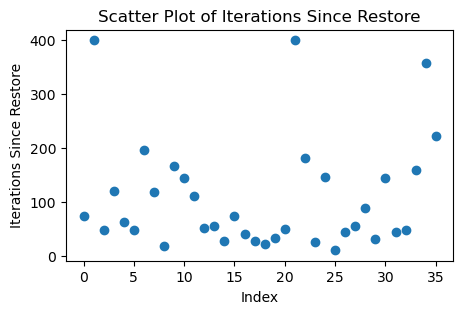

In [14]:
paths = [
    "/user/ml4723/Prj/NIC/ray_results/new_perf/ctx/5/run_2024-08-29_00-29-57/experiment_state-2024-08-29_00-29-58.json",
]
merged_results = merge_experiment_results(paths)

In [4]:
weekly_forecast_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/weekly_forecast_NN',
}
data_driven_net_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/data_driven_net',
}
fixed_quantile_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/fixed_quantile',
}
quantile_nv_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/quantile_nv',
}
just_in_time_paths = {
    1: '/user/ml4723/Prj/NIC/ray_results/cons/just_in_time',
}

#def custom_data_filler(out_row, reference_row):
#    out_row['path'] = reference_row['path']

results_interpretor = rri.RayResultsinterpreter()
df_weekly_forecast = results_interpretor.make_table(weekly_forecast_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_data_driven_net = results_interpretor.make_table(data_driven_net_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_fixed_quantile = results_interpretor.make_table(fixed_quantile_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_quantile_nv = results_interpretor.make_table(quantile_nv_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': [4, 6, 9, 13]})
df_weekly_forecast.insert(1, 'Architecture Class', "Weekly Forecast")
df_data_driven_net.insert(1, 'Architecture Class', "HDPO")
df_fixed_quantile.insert(1, 'Architecture Class', "Fixed Quantile")
df_quantile_nv.insert(1, 'Architecture Class', "Newsvendor")
df_just_in_time.insert(1, 'Architecture Class', "Oracle")

optimal_weeks = {
    4: 4.7298,
    6: 5.0385,
    9: 5.3489,
    13: 5.5832
}
df = pd.concat([df_weekly_forecast, df_data_driven_net, df_fixed_quantile, df_quantile_nv, df_just_in_time])

# Insert 'Optimal # of Weeks' next to 'Architecture Class' only for Weekly Forecast rows
architecture_class_index = df.columns.get_loc('Architecture Class')
df.insert(architecture_class_index + 1, 'Optimal # of Weeks', None)
df.loc[df['Architecture Class'] == 'Weekly Forecast', 'Optimal # of Weeks'] = df.loc[df['Architecture Class'] == 'Weekly Forecast', 'store_underage_cost'].map(optimal_weeks)

min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
df.drop(columns=['# of stores', '# of runs'], inplace=True)
# Define the custom order for Architecture Class
architecture_order = ['Oracle', 'HDPO', 'Weekly Forecast', 'Fixed Quantile', 'Newsvendor']
# Create a categorical column with the custom order
df['Architecture Class'] = pd.Categorical(df['Architecture Class'], categories=architecture_order, ordered=True)
# Sort the dataframe
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
# Move store_underage_cost to the first column
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

print(df.to_string(index=False))
df.to_csv('results.csv', index=False)
print("Results saved to comparison_results.csv")

 store_underage_cost Architecture Class Optimal # of Weeks  Train Loss    Dev Loss  Dev Gap %
                   4             Oracle               None -213.665006 -198.463167   0.000000
                   4               HDPO               None -161.395985 -150.136966  24.350211
                   4    Weekly Forecast             4.7298 -144.881375 -134.072153  32.444819
                   4     Fixed Quantile               None -150.145288 -139.585469  29.666814
                   4         Newsvendor               None -134.674537 -120.307394  39.380493
                   6             Oracle               None -320.510398 -297.704852   0.000000
                   6               HDPO               None -255.922236 -236.749878  20.474968
                   6    Weekly Forecast             5.0385 -238.705123 -220.377574  25.974477
                   6     Fixed Quantile               None -243.081326 -225.572379  24.229526
                   6         Newsvendor               None -

In [41]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
def custom_data_filler(out_row, reference_row):
    out_row['best_test_loss'] = reference_row['best_test_loss']
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [1, 2, 4, 8, 16, 32, 64], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}, custom_data_filler, sort_by='best_test_loss')
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'for_all_networks': [1, 2, 4, 8, 16, 32, 64], 'samples': [1, 2, 3, 4, 5], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}, custom_data_filler, sort_by='best_test_loss')
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
# df = pd.concat([df_ctx, df_gnn, df_gnn_mp, df_custom_stemb, df_vanilla])
df = pd.concat([df_ctx])

# Move 'master size' column next to 'context size'
if 'master' in df.columns:
    context_size_index = df.columns.get_loc('context size')
    master_size = df.pop('master')
    df.insert(context_size_index + 1, 'master', master_size)

min_test_loss = df.groupby(['# of stores'])['best_test_loss'].transform('min')
df['Test Gap %'] = ((df['best_test_loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
# df.sort_values(by=['# of stores', 'context size', 'master'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  context size  samples  learning_rate  Learning Rate  Train Loss   Dev Loss   Test Loss  # of runs   Test Gap %  best_test_loss
          50     Symmatry_Aware             8        1         0.0001         0.0001    5.650241   7.421216   10.879798          1    46.751336        8.233992
          50     Symmatry_Aware             8        1         0.0010         0.0010   49.578414  44.554602   41.513131          1   639.152508       41.472713
          50     Symmatry_Aware             8        1         0.0100         0.0100  288.772125  37.387215   34.642025          1   517.411742       34.642025
          50     Symmatry_Aware             8        2         0.0001         0.0001   18.192926  20.490166  119.765963          1   418.095789       29.069559
          50     Symmatry_Aware             8        2         0.0010         0.0010   11.473066  11.937699  148.274425          1   223.611793       18.157361
          50     Symmatry_Aware         

In [6]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN/50',
}
gnn_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_WISTEMB/50',
}
gnn_pna_wistemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_PNA_WISTEMB/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_PNA/50',
}
gnn_mp_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_message_passing/50',
}
gnn_noctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_NoCtx/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_NoCtx_PNA/50',
}
gnn_separation_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_Separation/50',
}
gnn_separation_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/GNN_Separation_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'context': [4, 8, 16, 32, 64]}, custom_data_filler)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_wistemb = results_interpretor.make_table(gnn_wistemb_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna_wistemb = results_interpretor.make_table(gnn_pna_wistemb_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_pna_wistemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_separation = results_interpretor.make_table(gnn_separation_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_separation.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_separation_pna = results_interpretor.make_table(gnn_separation_pna_paths, {'for_all_networks': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_separation_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_mp = results_interpretor.make_table(gnn_mp_paths, {'context': [4, 8, 16, 32, 64]}, custom_data_filler)
df_gnn_mp.rename(columns={'context': 'context size'}, inplace=True)

df_gnn_noctx = results_interpretor.make_table(gnn_noctx_paths, {}, custom_data_filler)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {}, custom_data_filler)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'master': [128, 512]}, custom_data_filler)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_wistemb.insert(1, 'Architecture Class', "GNN_WISTEMB")
df_gnn_mp.insert(1, 'Architecture Class', "GNN_MP")
df_gnn_pna_wistemb.insert(1, 'Architecture Class', "GNN_PNA_WISTEMB")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_separation.insert(1, 'Architecture Class', "GNN_Separation")
df_gnn_separation_pna.insert(1, 'Architecture Class', "GNN_Separation_PNA")
df_gnn_noctx.insert(1, 'Architecture Class', "GNN_NoCtx")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_gnn_separation_pna, df_gnn_pna])

# Move 'master size' column next to 'context size'
if 'master' in df.columns:
    context_size_index = df.columns.get_loc('context size')
    master_size = df.pop('master')
    df.insert(context_size_index + 1, 'master', master_size)

#min_test_loss = df.groupby(['# of stores', 'context size'])['Test Loss'].transform('min')
min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %(all)'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %(all)', df.pop('Test Gap %(all)'))
min_test_loss = df.groupby(['# of stores', 'context size'])['Test Loss'].transform('min')
df['Test Gap %(context)'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %(context)', df.pop('Test Gap %(context)'))
# df.sort_values(by=['# of stores', 'context size', 'master'], inplace=True)
df.sort_values(by=['# of stores', 'context size'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %(all)  Test Gap %(context)  # of runs
          50 GNN_Separation_PNA             4         0.0001    5.232822  5.212971   5.230135         0.222787             0.000000          9
          50            GNN_PNA             4         0.0010    6.694859  6.672745   6.691896        28.233871            27.948818          9
          50 GNN_Separation_PNA             8         0.0001    5.234111  5.213783   5.231656         0.251928             0.149143          9
          50            GNN_PNA             8         0.0010    5.227092  5.205777   5.223865         0.102632             0.000000          9
          50 GNN_Separation_PNA            16         0.0010    5.230073  5.208341   5.226016         0.143854             0.143854          9
          50            GNN_PNA            16         0.0010    5.221111  5.200564   5.218509         0.000000             0.000000          9

In [7]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_larger_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_larger_stemb/50',
}
gnn_relu_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_ReLU_stemb/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_NoCtx_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
sort_by = 'test_loss'
training_n_samples = [1]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_larger_stemb = results_interpretor.make_table(gnn_larger_stemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_larger_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_relu_stemb = results_interpretor.make_table(gnn_relu_stemb_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_relu_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention['training_n_samples'] = training_n_samples[0]
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")
df_gnn_relu_stemb.insert(1, 'Architecture Class', "GNN_ReLU_STEMB")
df_gnn_larger_stemb.insert(1, 'Architecture Class', "GNN_Larger_STEMB")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_attention, df_gnn_pna, df_gnn_noctx_pna, df_gnn_relu_stemb, df_gnn_larger_stemb, df_vanilla])
df.drop(columns=['Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Test Loss': 'mean',
    'best_train_loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Test Loss', '# of runs']]
df = df_avg

min_test_loss = 5.218509
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
df.rename(columns={'Train Loss': 'Train Loss(at best test loss)'}, inplace=True)
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss(at best test loss)  Test Loss  Test Gap %  # of runs
          50                GNN                   1                       5.538947   6.432312   23.259580        360
          50      GNN_Attention                   1                       5.077987   6.142445   17.704976        332
          50   GNN_Larger_STEMB                   1                       4.947377   6.359499   21.864285        324
          50      GNN_NoCtx_PNA                   1                       6.747120   7.348398   40.814133        108
          50            GNN_PNA                   1                       5.321012   6.353386   21.747159        360
          50     GNN_ReLU_STEMB                   1                       4.958621   6.475248   24.082342        324
          50     Symmatry_Aware                   1                       4.379046   5.959442   14.198182        360
          50            Vanilla                   1             

In [5]:
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_larger_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_larger_stemb/50',
}
gnn_relu_stemb_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_ReLU_stemb/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_NoCtx_PNA/50',
}
vanilla_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/vanilla/50',
}

def custom_data_filler(out_row, reference_row):
    pass
    # out_row['best_train_loss'] = reference_row['best_train_loss']
    #out_row['path'] = reference_row['path']
sort_by = 'train_loss'
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_larger_stemb = results_interpretor.make_table(gnn_larger_stemb_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_larger_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_relu_stemb = results_interpretor.make_table(gnn_relu_stemb_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_relu_stemb.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention['training_n_samples'] = 1
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_vanilla = results_interpretor.make_table(vanilla_paths, {'training_n_samples': [1], 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")
df_gnn_relu_stemb.insert(1, 'Architecture Class', "GNN_ReLU_STEMB")
df_gnn_larger_stemb.insert(1, 'Architecture Class', "GNN_Larger_STEMB")
df_vanilla.insert(1, 'Architecture Class', "Vanilla")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_pna, df_gnn_noctx_pna, df_gnn_attention, df_gnn_relu_stemb, df_gnn_larger_stemb, df_vanilla])
df.drop(columns=['Test Loss', 'Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', '# of runs']]
df = df_avg
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss  # of runs
          50                GNN                   1    4.560037        360
          50      GNN_Attention                   1    4.619906        324
          50   GNN_Larger_STEMB                   1    4.625154        324
          50      GNN_NoCtx_PNA                   1    4.351136        108
          50            GNN_PNA                   1    4.463108        360
          50     GNN_ReLU_STEMB                   1    4.644932        324
          50     Symmatry_Aware                   1    3.664529        360
          50            Vanilla                   1    2.990698        216


In [9]:
sort_by = 'test_loss'
def custom_data_filler(out_row, reference_row):
    out_row['best_train_loss'] = reference_row['best_train_loss']
    pass

ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_NoCtx_PNA/50',
}

training_n_samples = [8]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_attention, df_gnn_pna, df_gnn_noctx_pna])
df.drop(columns=['Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    'Test Loss': 'mean',
    'best_train_loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', 'Test Loss', '# of runs']]
df = df_avg

min_test_loss = 5.218509
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
df.rename(columns={'Train Loss': 'Train Loss(at best test loss)'}, inplace=True)
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss(at best test loss)  Test Loss  Test Gap %  # of runs
          50                GNN                 8.0                       9.300430  21.846577  318.636368         16
          50      GNN_Attention                 8.0                       6.481350   5.958268   14.175684         13
          50      GNN_NoCtx_PNA                 8.0                       5.805554   5.547534    6.304958         12
          50            GNN_PNA                 8.0                       6.524081   6.079937   16.507162         12
          50     Symmatry_Aware                 8.0                       6.036329   5.916184   13.369240         23


In [11]:
sort_by = 'train_loss'
def custom_data_filler(out_row, reference_row):
    pass
ctx_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/ctx/50',
}
gnn_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN/50',
}
gnn_attention_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_attention/50',
}
gnn_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_PNA/50',
}
gnn_noctx_pna_paths = {
    50: '/user/ml4723/Prj/NIC/ray_results/stable_bench_sample_efficiency/GNN_NoCtx_PNA/50',
}

training_n_samples = [8]
results_interpretor = rri.RayResultsinterpreter()
df_ctx = results_interpretor.make_table(ctx_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_ctx.rename(columns={'context': 'context size'}, inplace=True)

df_gnn = results_interpretor.make_table(gnn_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_attention = results_interpretor.make_table(gnn_attention_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_attention.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_pna = results_interpretor.make_table(gnn_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)
df_gnn_pna.rename(columns={'for_all_networks': 'context size'}, inplace=True)

df_gnn_noctx_pna = results_interpretor.make_table(gnn_noctx_pna_paths, {'training_n_samples': training_n_samples, 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}, custom_data_filler, sort_by=sort_by)

df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn_attention.insert(1, 'Architecture Class', "GNN_Attention")
df_gnn_pna.insert(1, 'Architecture Class', "GNN_PNA")
df_gnn_noctx_pna.insert(1, 'Architecture Class', "GNN_NoCtx_PNA")

# Concatenate all dataframes
# df = pd.concat([df_ctx, df_gnn, df_gnn_wistemb, df_gnn_mp, df_gnn_pna_wistemb, df_gnn_pna, 
#.                df_gnn_separation, df_gnn_separation_pna, df_gnn_noctx, df_gnn_noctx_pna, df_vanilla])
# df = pd.concat([df_ctx])
df = pd.concat([df_ctx, df_gnn, df_gnn_pna, df_gnn_noctx_pna, df_gnn_attention])
df.drop(columns=['Test Loss', 'Dev Loss', 'Learning Rate', 'samples'], inplace=True)

df_avg = df.groupby(['# of stores', 'Architecture Class', 'training_n_samples']).agg({
    'Train Loss': 'mean',
    '# of runs': 'sum'
}).reset_index()
df_avg = df_avg[['# of stores', 'Architecture Class', 'training_n_samples', 'Train Loss', '# of runs']]
df = df_avg
#df.drop(columns=['# of runs'], inplace=True)

print(df.to_string(index=False))

 # of stores Architecture Class  training_n_samples  Train Loss  # of runs
          50                GNN                 8.0    7.173801         17
          50      GNN_Attention                 8.0    6.300957         16
          50      GNN_NoCtx_PNA                 8.0    5.475514         12
          50            GNN_PNA                 8.0    6.524081         13
          50     Symmatry_Aware                 8.0    5.002208         24
